In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import findwells as fw

## Model Domain Properties

This notebook is in the `notebooks/` folder of the `pfas/` directory.

The model files will be stored in the `peterson-test/` directory. To access the files in that folder, we have to specify that our workspace is one level back (denoted by the `../`). Our relative file path (from current location to target location) `../peterson-test/`. 

In [2]:
workspace = '../input-files/'
sim_name = 'peterson'

We will define the model domain the same way as the last notebook:

In [3]:
nrow = 972    # Number of rows in domain
ncol = 700    # Number of columns in domain
dr = dc = 20  # Equal spacing for x- and y-cells
nlay = 1      # single layer model

start_date_time = '1970-01-01'  # Start date of simulation
nper = 446                      # Number of stress periods

# Geolocation of model grid
rot = 30
xorigin = 525532.4922815983
yorigin = 4276158.318078171

Here, we can load in the discretization parameters for the model

# Load in Simulation

After creating the simulation and the groundwater flow model in the previous notebook, we would like to make a groundwater transport model to simulate how toxins are moving under the ground in Colorado Springs.

In the last notebook, we finished off by writing the simulation. We can load that simulation into this notebook and add the transport model to simulation here.

In [35]:
# Load in the Flopy simulation object
sim = flopy.mf6.MFSimulation.load(
    sim_name=sim_name, 
    sim_ws=workspace, 
    exe_name="../bin/mf6.exe", 
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package riv...
    loading package obs...
    loading package wel...
    loading package chd...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package rch...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package mst...
    loading package ist...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading exchange package gwf-gwt_exg_0...
  loading solution package peterson_flow...
  loading solution package peterson_pfos...


Now we can load in the groundwater flow model using `sim.get_model()`

In [5]:
gwf = sim.get_model('peterson_flow')

# Create Groundwater Transport Model

Simulation is loaded in and GWF model has been loaded as well. Now we can make the groundwater transport model, `gwt`. Like with the GWF model, we have many DAT files containing important parameters about how solutes move through the groundwater.

## Load in DAT files

Lets load in some of these DAT files and see how the transport parameters vary across the model domain

In [6]:
rho_b = np.loadtxt('../input-files/data-files/tran-bulk-density.dat')
dispersion = np.loadtxt('../input-files/data-files/tran-dispersion.dat')
porosity = np.loadtxt('../input-files/data-files/tran-porosity.dat')
immobile_porosity = np.loadtxt('../input-files/data-files/tran-immobile-porosity.dat')

kd_pfos = np.loadtxt('../input-files/data-files/tran-Kd-pfos.dat')
kd_pfoa = np.loadtxt('../input-files/data-files/tran-Kd-pfoa.dat')
kd_pfhxs = np.loadtxt('../input-files/data-files/tran-Kd-pfhxs.dat')

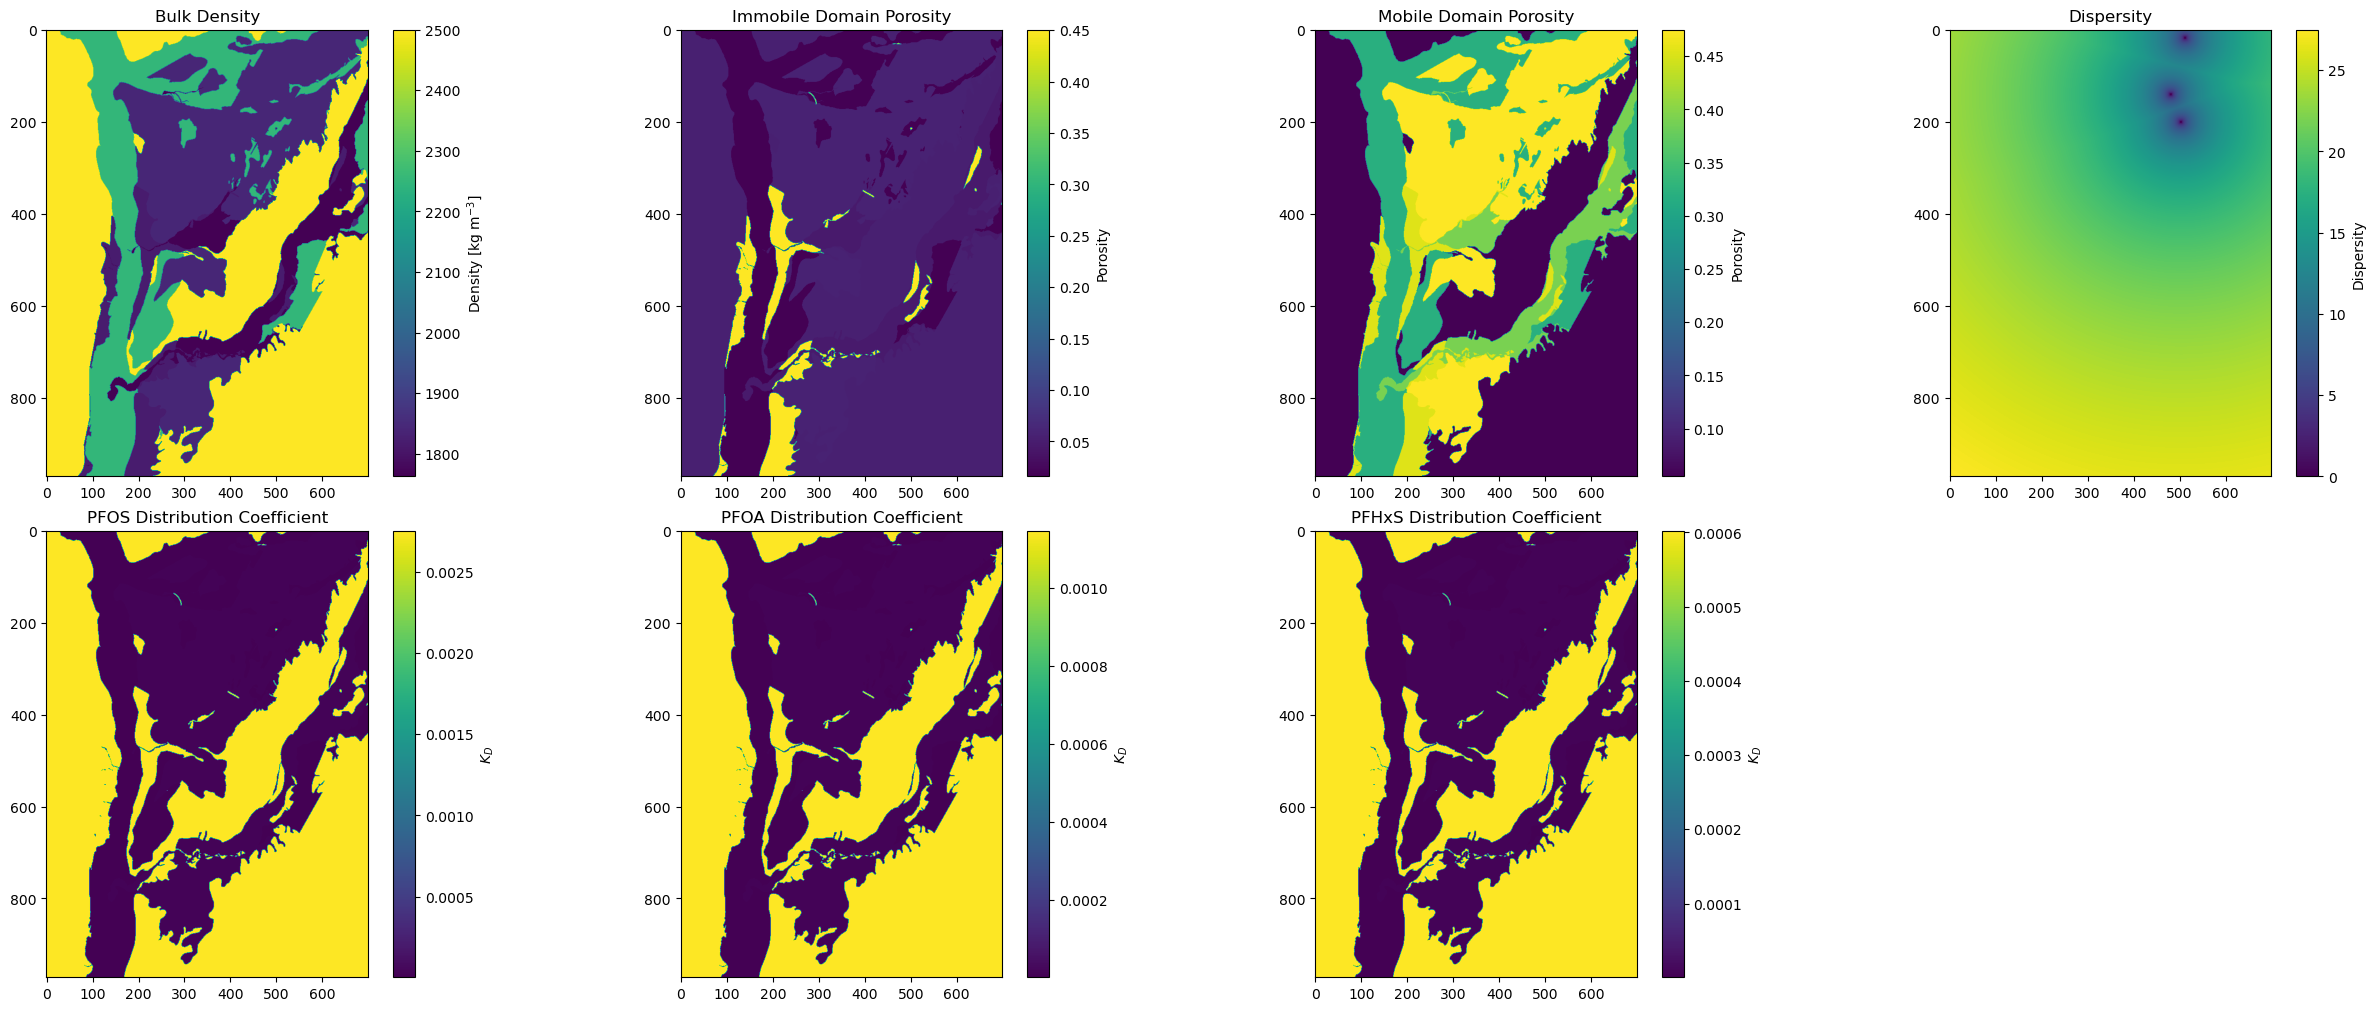

In [7]:
fig, axs = plt.subplots(ncols=4, nrows=2, layout='constrained', figsize=(25,10))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs.flatten()

cs1 = ax1.imshow(rho_b)
fig.colorbar(cs1, ax=ax1, label='Density [kg m$^{-3}$]')
ax1.set_title('Bulk Density')

cs2 = ax2.imshow(immobile_porosity)
fig.colorbar(cs2, ax=ax2, label='Porosity')
ax2.set_title('Immobile Domain Porosity')

cs3 = ax3.imshow(porosity)
fig.colorbar(cs3, ax=ax3, label='Porosity')
ax3.set_title('Mobile Domain Porosity')

cs4 = ax4.imshow(dispersion)
fig.colorbar(cs4, ax=ax4, label='Dispersity')
ax4.set_title('Dispersity')

cs5 = ax5.imshow(kd_pfos)
fig.colorbar(cs5, ax=ax5, label='$K_D$')
ax5.set_title('PFOS Distribution Coefficient')

cs6 = ax6.imshow(kd_pfoa)
fig.colorbar(cs6, ax=ax6, label='$K_D$')
ax6.set_title('PFOA Distribution Coefficient')

cs7 = ax7.imshow(kd_pfhxs)
fig.colorbar(cs7, ax=ax7, label='$K_D$')
ax7.set_title('PFHxS Distribution Coefficient')

ax8.axis('off')
plt.show()

## Initialize GWT object

Now we can make the groundwater transport model object. It's name is `peterson_tran`, and all of the input files will stored in the `transport-files/` folder in the `input-files/` directory, similar to the GWF model.

In [8]:
pfos_name = 'peterson_pfos'

# Create the Flopy groundwater flow (gwf) model object
pfos_nam_file = f"{pfos_name}.nam"
gwt = flopy.mf6.ModflowGwt(
    sim,
    modelname=pfos_name,
    model_nam_file=pfos_nam_file
)

## Create Iterative Model Solver for GWT model

Just as with the GWF model, we have to create an IMS package and register it with the GWT model.

In [9]:
# IMS package for the GWT model
ims_pfos = flopy.mf6.ModflowIms(
    sim,
    pname='ims_pfos',
    filename='peterson_pfos.ims',
    complexity='COMPLEX',
    linear_acceleration='BICGSTAB',
    outer_maximum=100,
    inner_maximum=500,
    inner_dvclose=0.1,
    outer_dvclose=0.1,
    rcloserecord=8460, 
    no_ptcrecord='FIRST'
)

sim.register_ims_package(ims_pfos, [pfos_name])  # Assign ims_gwt to the GWT model

## GWT Discretization

In [10]:
# Exact same as GWF dis setup
dis_gwt = flopy.mf6.ModflowGwtdis(
    gwt,
    pname='dis',
    length_units='METERS',
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dr,
    delc=dc,
    top='data-files/dis-top-elev.dat',
    botm='data-files/dis-bedrock-elev.dat',
    idomain='data-files/dis-idomain.dat',
    xorigin=xorigin,
    yorigin=yorigin,
    angrot=rot,
)

In [11]:
ic = flopy.mf6.ModflowGwtic(
    gwt,
    strt=0,
    pname='ic',
)

## Advection package

In [12]:
adv = flopy.mf6.ModflowGwtadv(
    gwt,
    scheme='TVD',
    pname='adv',
)

## Dispersion Package

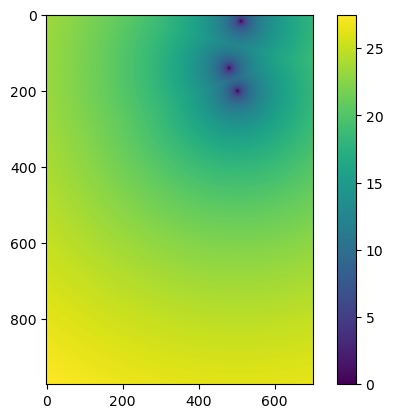

In [13]:
dispersion = np.loadtxt('../input-files/data-files/tran-dispersion.dat')

fig, ax = plt.subplots()

cs = ax.imshow(dispersion)
fig.colorbar(cs, ax=ax)

In [14]:
alh =  {'filename':'data-files/tran-dispersion.dat', 'factor': 1.0}
ath1 = {'filename':'data-files/tran-dispersion.dat', 'factor': 0.1}
atv =  {'filename':'data-files/tran-dispersion.dat', 'factor':0.01}

dsp = flopy.mf6.ModflowGwtdsp(
    gwt,
    alh=alh,
    ath1=ath1,
    atv=atv,
    pname='dsp',
)

## MST Package

Text(0.5, 1.0, 'PFHXS kD')

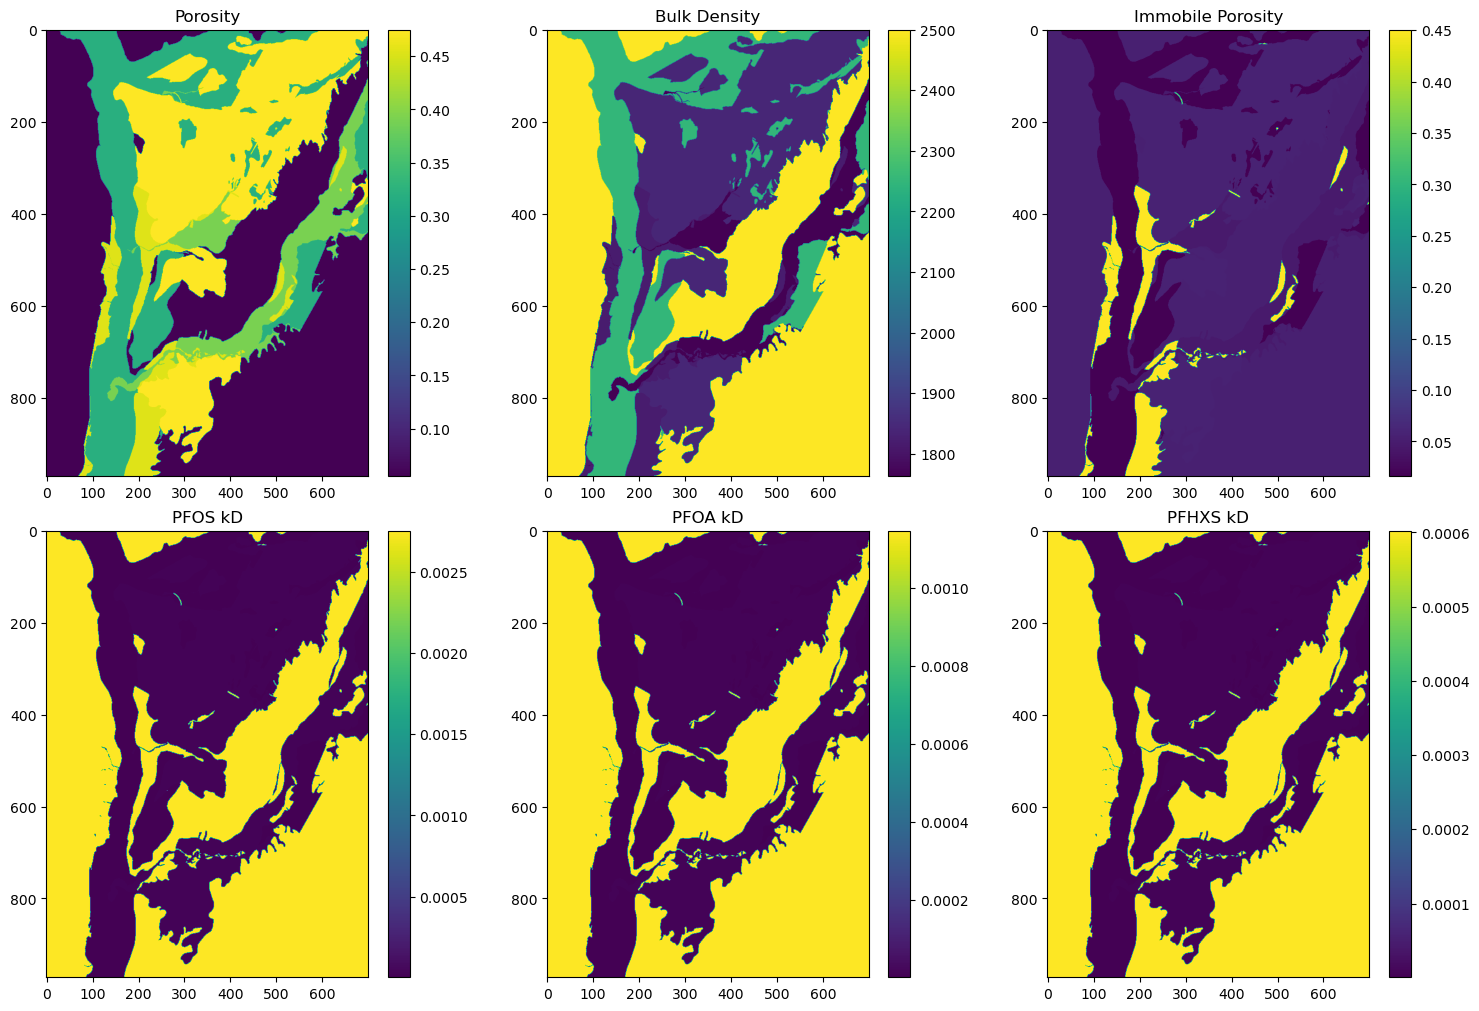

In [15]:
por = np.loadtxt('../input-files/data-files/tran-porosity.dat')
rho_b = np.loadtxt('../input-files/data-files/tran-bulk-density.dat')
sr = np.loadtxt('../input-files/data-files/tran-immobile-porosity.dat')
kd_pfos = np.loadtxt('../input-files/data-files/tran-Kd-pfos.dat')
kd_pfoa = np.loadtxt('../input-files/data-files/tran-Kd-pfoa.dat')
kd_pfhxs = np.loadtxt('../input-files/data-files/tran-Kd-pfhxs.dat')

fig, axs = plt.subplots(nrows=2, ncols=3, layout='constrained', figsize=(15,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()

cs = ax1.imshow(por)
fig.colorbar(cs, ax=ax1)
ax1.set_title('Porosity')

cs = ax2.imshow(rho_b)
fig.colorbar(cs, ax=ax2)
ax2.set_title('Bulk Density')

cs = ax3.imshow(sr)
fig.colorbar(cs, ax=ax3)
ax3.set_title('Immobile Porosity')

cs = ax4.imshow(kd_pfos)
fig.colorbar(cs, ax=ax4)
ax4.set_title('PFOS kD')

cs = ax5.imshow(kd_pfoa)
fig.colorbar(cs, ax=ax5)
ax5.set_title('PFOA kD')

cs = ax6.imshow(kd_pfhxs)
fig.colorbar(cs, ax=ax6)
ax6.set_title('PFHXS kD')

In [16]:
mst = flopy.mf6.ModflowGwtmst(
    gwt,
    sorption='LINEAR',
    porosity='data-files/tran-porosity.dat',
    bulk_density='data-files/tran-bulk-density.dat',
    distcoef='data-files/tran-Kd-pfos.dat'
)

## Create IST Package

In [17]:
ist = flopy.mf6.ModflowGwtist(
    gwt,
    pname='ist',
    sorption='LINEAR',
    porosity='data-files/tran-immobile-porosity.dat',
    volfrac=0.1,
    zetaim=0.001,
    bulk_density='data-files/tran-bulk-density.dat',
    distcoef=0.002754
)

## Create Recharge package for PFAS transport

I very much need to reorganize this section and explain wtf is going on

In [18]:
conc_ts = pd.read_csv('../input-files/data-files/tran-concentration-timeseries.csv')
conc_ts.head()

,Time,PFHxS_T,PFOA_T,PFOS_T,Precip,PFHxS_G,PFOA_G,PFOS_G
0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.000508,0.0,0.0,0.0


In [19]:
afff_concentration_factor = 2.0   # Factor to modify concentrations
golf_concentration_factor = 0.10  # Factor to modify concentrations

# Multiply source areas by factor
conc_ts.loc[:,['PFHxS_T', 'PFOA_T', 'PFOS_T']] *= afff_concentration_factor
conc_ts.loc[:,['PFHxS_G', 'PFOA_G', 'PFOS_G']] *= golf_concentration_factor

In [20]:
ts_in = {
    'filename':'peterson_solutes.ts',
    'time_series_namerecord':list(conc_ts.columns.values[1:]),
    'interpolation_methodrecord':[('stepwise', 'stepwise', 'stepwise','stepwise', 'stepwise', 'stepwise', 'stepwise')],
    'timeseries':list(conc_ts.itertuples(index=False, name=None)),
}

In [21]:
# Read in locations for contamination source cells
sources = pd.read_csv('../input-files/data-files/tran-source-cells.csv')

# Define the rch period data (e.g. infiltration rate)
recharge = 'Precip'

# Keyword to pull PFAS conc for training areas
aux_pfos_T = 'PFOS_T'
aux_pfoa_T = 'PFOA_T'
aux_pfhxs_T = 'PFHxS_T'

# Keyword to pull PFAS conc for Golf Course
aux_pfos_G = 'PFOS_G'
aux_pfoa_G = 'PFOA_G'
aux_pfhxs_G = 'PFHxS_G'

aux_mult = 0.1

rch_perioddata = {}
for iper in range(446):
    periodstep = []
    
    for i, cell in sources.iterrows():
        j, k = cell['x'], cell['y']
        cellid = (0, j-1, k-1)

        if cell['type'] == 'AFFF':  # Assuming the 3rd column is named 'type'
            pfos = aux_pfos_T
            pfoa = aux_pfoa_T
            pfhxs = aux_pfhxs_T
            
        if cell['type'] == 'Golf':  # Assuming the 3rd column is named 'type'
            pfos = aux_pfos_G
            pfoa = aux_pfoa_G
            pfhxs = aux_pfhxs_G

        # Append the data for this cell
        periodstep.append([cellid, recharge, pfos, pfoa, pfhxs, aux_mult])
        
    rch_perioddata[iper] = periodstep

In [22]:
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    auxiliary=['PFOS', 'PFOA', 'PFHxS', 'MULT'],
    auxmultname='MULT',
    timeseries=ts_in,
    maxbound=2414,
    stress_period_data=rch_perioddata,
    pname='rch_solutes'
)

## Create SSM package

In [23]:
ssm = flopy.mf6.ModflowGwtssm(
    gwt, 
    pname='ssm',
    sources=['rch_solutes', 'AUX', 'PFOS']
)

## Create Observation Wells

### Downstream Targets

In [24]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')

idomain = np.loadtxt('../input-files/data-files/dis-idomain.dat')

In [25]:
well_data = {}

for i, well in downstream_wells.iterrows():
    # Extract the cell's row and column indices
    layer, row, col = 0, int(well['x']), int(well['y'])  # Layer hardcoded to 0

    # Check cell in valid domain
    if idomain[row, col] == 1:
        well_data[well['Well Name']] = (layer, row, col)

    else:
        well_data[well['Well Name']] = None
        print(f"Well {well['Well Name']} is in an inactive cell ({layer}, {row}, {col})")

Well PND is in an inactive cell (0, 720, 191)


In [26]:
obs_data = []

for name, cell in well_data.items():
    if cell:
        obs_data.append((f"{name}", 'CONCENTRATION', cell))

### Upstream Targets

In [27]:
df = pd.read_csv('../input-files/data-files/tran-PFOS-targets.csv')
df.head()

,Well_ID,SDate,Result_ngL,x,y,geometry
0,DeicePondsNorth,2016-05-04,1600.0,525321.792579,4.294213e+06,POINT (525321.7925785515 4294212.816407697)
1,DeicePondsNorth,2018-08-18,530.0,525321.792579,4.294213e+06,POINT (525321.7925785515 4294212.816407697)
2,DeicePondsSouth,2018-08-18,580.0,525252.568741,4.294135e+06,POINT (525252.5687410067 4294134.917400108)
3,MW1-1,2018-08-08,40.0,524955.187127,4.297973e+06,POINT (524955.1871265842 4297973.256488133)
4,MW1-2,2016-11-04,9700.0,524931.543572,4.297637e+06,POINT (524931.5435724071 4297637.005614797)


In [28]:
upstream_wells = {}
for _, row in df.iterrows():
    cell = fw.locate_well_rotated(row['x'], row['y'], xorigin, yorigin, 20, 20, 972, 700, rot)
    
    if cell:
        upstream_wells[row['Well_ID']] = (0, cell[0], cell[1])

In [29]:
for name, cell in upstream_wells.items():
    if cell:
        obs_data.append((f"{name}", 'CONCENTRATION', cell))

In [30]:
obs_package = flopy.mf6.ModflowUtlobs(
    gwt,
    pname='obs_pfos',
    digits=10,
    print_input=True,
    continuous={'../output-files/pfos_obs.csv':obs_data}
)

## Create Output Control Package

In [31]:
oc_gwt = flopy.mf6.ModflowGwtoc(
    gwt,
    pname='oc_pfos',
    concentration_filerecord='../output-files/PFOS_conc.ucn',
    saverecord= ['CONCENTRATION', 'ALL'],
    printrecord= ['CONCENTRATION', 'ALL']
)

# Write and Run Simulation

Now that everything's been initialized, we can write the simulation

In [32]:
exg = flopy.mf6.ModflowGwfgwt(
    sim, exgmnamea='peterson_flow', exgmnameb=pfos_name, filename='peterson_pfos.gwfgwt'
)

In [33]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package peterson_flow...
  writing solution package ims_pfos...
  writing package peterson_pfos.gwfgwt...
  writing model peterson_flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package riv...
    writing package obs...
    writing package wel...
    writing package chd...
    writing package sto...
    writing package rcha_tas...
    writing package rcha...
    writing package oc...
    writing package rch_solutes...
    writing package ts_0...
  writing model peterson_pfos...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ist...
    writing package ssm...
    writing package obs_pfos...
    writing package oc_pfos...


Run the simulation

In [36]:
## Uncomment this cell to run the simulation with the flow and PFOS transport model

# success, buff = sim.run_simulation(report=True)
# assert success

FloPy is using the following executable to run the model: ..\..\mf6\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:06:57 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government s

KeyboardInterrupt: 